# Machine learning algorithm to forecast intracompartmental pressure

## Train TensorFlow Lite regression algorithm

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Train regression model

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset fsr_data.csv
df = pd.read_csv('/content/drive/MyDrive/SEF 2023-2024/TinyML/fsr_data.csv')

# Prepare data for training
scaler = MinMaxScaler()
df[['fsr_1', 'fsr_2','fsr_3','fsr_4','fsr_5','fsr_6','gyro', 'ground_truth']] = scaler.fit_transform(df[['fsr_1', 'fsr_2','fsr_3','fsr_4','fsr_5','fsr_6','gyro', 'ground_truth']])

# Split data into features (X) and target (y)
X = df[['fsr_1', 'fsr_2','fsr_3','fsr_4','fsr_5','fsr_6','gyro']]
y = df['ground_truth']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define input layers
input_layer = tf.keras.Input(shape=(7))

# Create the model architecture
x = tf.keras.layers.Dense(64, activation='relu')(input_layer) # 64 neurons + relu for nonlinearity
x = tf.keras.layers.Dropout(0.5)(x) # prevent overfitting
x = tf.keras.layers.Dense(32, activation='relu')(x)  # 32 neurons + relu for nonlinearity
x = tf.keras.layers.Dropout(0.5)(x) # prevent overfitting

# Output layer
output_layer = tf.keras.layers.Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/SEF 2023-2024/TinyML/model.tflite', 'wb') as f:
    f.write(tflite_model)

Epoch 1/10
3/3 [==============================] - 1s 95ms/step - loss: 0.4338 - val_loss: 0.1775
Epoch 2/10
3/3 [==============================] - 0s 17ms/step - loss: 0.3238 - val_loss: 0.0942
Epoch 3/10
3/3 [==============================] - 0s 15ms/step - loss: 0.2248 - val_loss: 0.0408
Epoch 4/10
3/3 [==============================] - 0s 14ms/step - loss: 0.2106 - val_loss: 0.0148
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 0.1801 - val_loss: 0.0069
Epoch 6/10
3/3 [==============================] - 0s 16ms/step - loss: 0.1437 - val_loss: 0.0066
Epoch 7/10
3/3 [==============================] - 0s 16ms/step - loss: 0.1544 - val_loss: 0.0075
Epoch 8/10
3/3 [==============================] - 0s 17ms/step - loss: 0.1657 - val_loss: 0.0074
Epoch 9/10
3/3 [==============================] - 0s 15ms/step - loss: 0.1615 - val_loss: 0.0065
Epoch 10/10
3/3 [==============================] - 0s 15ms/step - loss: 0.1106 - val_loss: 0.0062



##Generate machine learning png architecture diagram


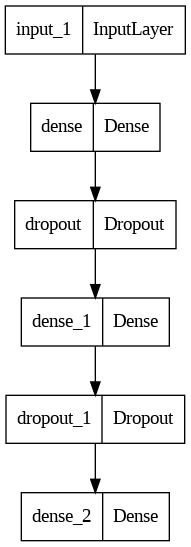

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

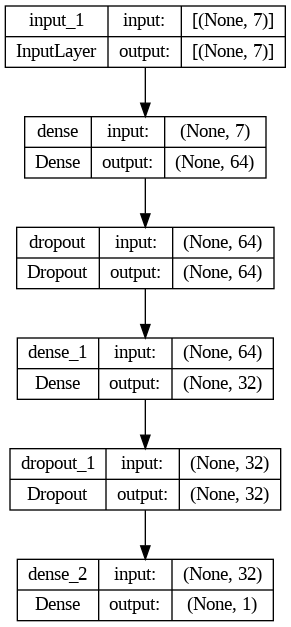

In [ ]:
tf.keras.utils.plot_model(model, "model_with_shape.png", show_shapes=True)

## Save the TFLite model in .h format (to work with Arduino Sketch)

In [ ]:
tflite_model_path = '/content/drive/My Drive/SEF 2023-2024/TinyML/model.h'
with open(tflite_model_path, 'w') as f:  # Open the file in text mode
    f.write('#ifndef MODEL_H\n')
    f.write('#define MODEL_H\n\n')
    f.write('#include <cstdint>\n\n')
    f.write('const uint8_t model[] = {\n')
    for byte in tflite_model:
        f.write(hex(byte) + ', ')
    f.write('\n};\n\n#endif\n')

# Print the path for reference
print(f'TFLite model saved as {tflite_model_path}')

## Evaluate model performance (regression)

In [ ]:
# Model regression statistics

# Evaluate the Model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Predictions on Test Set
y_pred = model.predict(X_test)

# Calculate additional performance metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R-squared on Test Set: {r2}')

NameError: ignored

## Manually test trained model

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
model_path = '/content/drive/My Drive/SEF 2023-2024/TinyML/model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Define a function to get input from the user
def get_user_input():
    # Ask the user for input values
    fsr_1 = float(input("Enter FSR 1 value: "))
    fsr_2 = float(input("Enter FSR 2 value: "))
    fsr_3 = float(input("Enter FSR 3 value: "))
    fsr_4 = float(input("Enter FSR 4 value: "))
    fsr_5 = float(input("Enter FSR 5 value: "))
    fsr_6 = float(input("Enter FSR 6 value: "))
    gyro = float(input("Enter gyro value: "))

    # Create a numpy array with the user input
    user_input = np.array([fsr_1, fsr_2, fsr_3, fsr_4, fsr_5, fsr_6, gyro], dtype=np.float32).reshape(1, 7)
    return user_input

# Get user input
processed_data = get_user_input()

# Set input tensor
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], processed_data)

# Run inference
interpreter.invoke()

# Get output tensor
output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the output data as needed
print("Processed Input Data:", processed_data)
print("Output Data:", output_data)